In [1]:
# 미래에 python3로의 호환성 확보를 위함
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# 압축 풀고, 파일을 다루고, 시간을 재고, ...
import gzip
import os
import sys
import time

# 그림/그래프 출력
%matplotlib inline
import matplotlib.pyplot as plt

import numpy
import tensorflow as tf

In [2]:
WORK_DIRECTORY = 'data'
IMAGE_SIZE = 28  # MNIST는 28x28 흑백 이미지들로 구성됩니다.
NUM_CHANNELS = 1
PIXEL_DEPTH = 255
NUM_LABELS = 10
VALIDATION_SIZE = 5000  # Size of the validation set.
SEED = 31725
BATCH_SIZE = 50
NUM_EPOCHS = 10
EVAL_BATCH_SIZE = 1000
EVAL_FREQUENCY = 200  # Number of steps between evaluations.

In [3]:
# Get the data.
train_data_filename = 'train-images-idx3-ubyte.gz'
train_labels_filename ='train-labels-idx1-ubyte.gz'
test_data_filename = 't10k-images-idx3-ubyte.gz'
test_labels_filename = 't10k-labels-idx1-ubyte.gz'

In [4]:
def extract_data(filename, num_images):
  """Extract the images into a 4D tensor [image index, y, x, channels].

  Values are rescaled from [0, 255] down to [-0.5, 0.5].
  """
  print('Extracting', filename)
  with gzip.open(WORK_DIRECTORY+'/'+filename) as bytestream:
    bytestream.read(16)
    buf = bytestream.read(IMAGE_SIZE * IMAGE_SIZE * num_images * NUM_CHANNELS)
    data = numpy.frombuffer(buf, dtype=numpy.uint8).astype(numpy.float32)
    data = (data - (PIXEL_DEPTH / 2.0)) / PIXEL_DEPTH
    data = data.reshape(num_images, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS)
    return data

In [5]:
def extract_labels(filename, num_images):
  """Extract the labels into a vector of int64 label IDs."""
  print('Extracting', filename)
  with gzip.open(WORK_DIRECTORY+'/'+filename) as bytestream:
    bytestream.read(8)
    buf = bytestream.read(1 * num_images)
    labels = numpy.frombuffer(buf, dtype=numpy.uint8).astype(numpy.int64)
  return labels

In [6]:
# Extract it into numpy arrays.
train_data = extract_data(train_data_filename, 60000)
train_labels = extract_labels(train_labels_filename, 60000)
test_data = extract_data(test_data_filename, 10000)
test_labels = extract_labels(test_labels_filename, 10000)

Extracting train-images-idx3-ubyte.gz
Extracting train-labels-idx1-ubyte.gz
Extracting t10k-images-idx3-ubyte.gz
Extracting t10k-labels-idx1-ubyte.gz


(60000, 28, 28, 1) (60000,)
(10000, 28, 28, 1) (10000,)
0


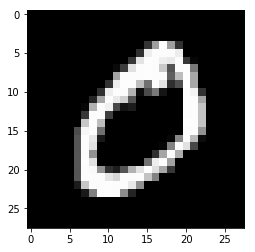

In [7]:
print(train_data.shape,train_labels.shape)
print(test_data.shape,test_labels.shape)
print(train_labels[1])
plt.imshow(train_data[1].reshape(28,28), cmap='gray', interpolation='none')

In [8]:
# Generate a validation set.
validation_data = train_data[:VALIDATION_SIZE, ...]
validation_labels = train_labels[:VALIDATION_SIZE]
train_data = train_data[VALIDATION_SIZE:, ...]
train_labels = train_labels[VALIDATION_SIZE:]

In [9]:
# The variables below hold all the trainable weights. They are passed an
# initial value which will be assigned when we call:
# {tf.global_variables_initializer().run()}

# 첫번째 conv layer를 위한 weight와 bias, 5x5 filter, depth 6
conv1_weights = tf.Variable(
  tf.truncated_normal([5, 5, NUM_CHANNELS, 6],  
                      stddev=0.1,
                      seed=SEED, dtype=tf.float32))
conv1_biases = tf.Variable(tf.zeros([6], dtype=tf.float32))

# 두번째 conv layer를 위한 weight와 bias, 5x5 filter, depth 16
conv2_weights = tf.Variable(tf.truncated_normal(  
  [5, 5, 6, 16], stddev=0.1,
  seed=SEED, dtype=tf.float32))
conv2_biases = tf.Variable(tf.constant(0.1, shape=[16], dtype=tf.float32))

# 세번째 conv layer를 위한 weight와 bias, 5x5 filter, depth 120
conv3_weights = tf.Variable(tf.truncated_normal(  
  [5, 5, 16, 120], stddev=0.1,
  seed=SEED, dtype=tf.float32))
conv3_biases = tf.Variable(tf.constant(0.1, shape=[120], dtype=tf.float32))

# 첫번째 fully connected layer, depth 84
fc1_weights = tf.Variable(  
  tf.truncated_normal([120, 84],
                      stddev=0.1,
                      seed=SEED,
                      dtype=tf.float32))
fc1_biases = tf.Variable(tf.constant(0.1, shape=[84], dtype=tf.float32))

# LeNet-5의 마지막 layer이자, 두번째 fully connected layer, depth 10
fc2_weights = tf.Variable(tf.truncated_normal([84, NUM_LABELS],  
                                            stddev=0.1,
                                            seed=SEED,
                                            dtype=tf.float32))
fc2_biases = tf.Variable(tf.constant(0.1, shape=[NUM_LABELS], dtype=tf.float32))

In [10]:
# We will replicate the model structure for the training subgraph, as well
# as the evaluation subgraphs, while sharing the trainable parameters.
"""The Model definition."""

# placeholder를 선언한다. {x: 데이터, y: 레이블}
x = tf.placeholder(tf.float32, [None, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS])
y = tf.placeholder(tf.int64, [None,])

# 1. 첫번재 conv layer
# 2D convolution, with 'SAME' padding (i.e. the output feature map has
# the same size as the input). Note that {strides} is a 4D array whose
# shape matches the data layout: [image index, y, x, depth].
conv = tf.nn.conv2d(x,
                conv1_weights,
                strides=[1, 1, 1, 1],
                padding='SAME')

actv = tf.nn.tanh(tf.nn.bias_add(conv, conv1_biases))
print(actv.get_shape().as_list())

# 2. 첫번째 Max pooling layer, LeNet-5에서는 Subsampling layer라고 불렀다.
# Max pooling. The kernel size spec {ksize} also follows the layout of
# the data. Here we have a pooling window of 2, and a stride of 2.
pool = tf.nn.max_pool(actv,
                  ksize=[1, 2, 2, 1],
                  strides=[1, 2, 2, 1],
                  padding='SAME')
print(pool.get_shape().as_list())

# 3. 두번째 conv layer
conv = tf.nn.conv2d(pool,
                conv2_weights,
                strides=[1, 1, 1, 1],
                padding='VALID')

actv = tf.nn.tanh(tf.nn.bias_add(conv, conv2_biases))
print(actv.get_shape().as_list())

# 4. 두번째 max pooling layer
pool = tf.nn.max_pool(actv,
                  ksize=[1, 2, 2, 1],
                  strides=[1, 2, 2, 1],
                  padding='SAME')
print(pool.get_shape().as_list())

# 5. 세번째 conv layer
conv = tf.nn.conv2d(pool,
                conv3_weights,
                strides=[1, 1, 1, 1],
                padding='VALID')

actv = tf.nn.tanh(tf.nn.bias_add(conv, conv3_biases))
actv_shape = actv.get_shape().as_list()
print(actv_shape)

# fully connected layer 연산을 적용하기 전에, vector로 변환이 필요하다. (여기서는 batch가 있기 때문에 2차원)
reshape = tf.reshape(
    actv,
    [-1, actv_shape[1] * actv_shape[2] * actv_shape[3]])
print(reshape.get_shape().as_list())

# 6. 첫번째 fully-connected layer
hidden = tf.nn.tanh(tf.matmul(reshape, fc1_weights) + fc1_biases)
print(hidden.get_shape().as_list())
# adding dropout?

# 7. 두번째 fully-connected layer이자, 네트워크의 최종 결과 (one-hot encode 되어 있다.)
logits = tf.matmul(hidden, fc2_weights) + fc2_biases
print(logits.get_shape().as_list())

[None, 28, 28, 6]
[None, 14, 14, 6]
[None, 10, 10, 16]
[None, 5, 5, 16]
[None, 1, 1, 120]
[None, 120]
[None, 84]
[None, 10]


In [11]:
# Training computation: logits + cross-entropy loss.
# tf.reduce mean: batch 단위로 나온 loss를 하나로 합쳐 평균을 구해주는 함수
# tf.nn.sparse_softmax_cross_entropy_with_logits: one-hot encode되어 있는 최종 output을 가지고,
#                                                 softmax + cross entropy loss를 구한다.

loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
    labels=y, logits=logits))
# L2 regularizers can be added!
# L2 regularization for the fully connected parameters.
#regularizers = (tf.nn.l2_loss(fc1_weights) + tf.nn.l2_loss(fc2_weights))
# Add the regularization term to the loss.
#loss += 5e-4 * regularizers
# Predictions for the current training minibatch.

# prediction의 경우에는 간단하게, 10개의 vector에서 softmax를 통해 결과값(확률)을 예측하면 그만이다.
prediction = tf.nn.softmax(logits)

In [12]:
def error_rate(predictions, labels):
  """Return the error rate based on dense predictions and sparse labels."""
  return 100.0 - (
      100.0 *
      numpy.sum(numpy.argmax(predictions, 1) == labels) /
      predictions.shape[0])

In [13]:
num_epochs = NUM_EPOCHS
train_size = train_labels.shape[0]
validation_size = validation_labels.shape[0]
val_steps = validation_size//EVAL_BATCH_SIZE
print(train_size, validation_size, val_steps)

55000 5000 5


In [14]:
# global_step은 mini-batch마다 1씩 증가하면서 learning_rate decay를 수행해주는 변수
global_step = tf.Variable(0, dtype=tf.float32)

# Decay once per epoch, using an exponential schedule starting at 0.1.
learning_rate = tf.train.exponential_decay(
  learning_rate = 0.1,                # Base learning rate.
  global_step = global_step * BATCH_SIZE,  # Current index into the dataset.
  decay_steps = train_size,          # Decay step.
  decay_rate = 0.85,                # Decay rate.
  staircase=True)

# Use simple sgd for the optimization.
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss,global_step=global_step)
# try other optimizer?
#optimizer = tf.train.MomentumOptimizer(learning_rate,momentum=0.9).minimize(loss,global_step=global_step)

# Create a local session to run the training.
start_time = time.time()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True, gpu_options={'allow_growth':True})) as sess:
  
  # Run all the initializers to prepare the trainable parameters.
  tf.global_variables_initializer().run()
  print('Initialized!')
    
  # Loop through training steps.
  for step in range(int(num_epochs * train_size) // BATCH_SIZE + 1):
    # Compute the offset of the current minibatch in the data.
    # Note that we could use better randomization across epochs.
    # 여기서는 전체 데이터 중 mini-batch만큼을 떼어내서 학습을 진행하는데 그 mini-batch별 인덱스를 계산하고 있다. (offset)
    offset = (step * BATCH_SIZE) % (train_size - BATCH_SIZE)
    batch_data = train_data[offset:(offset + BATCH_SIZE), ...]
    batch_labels = train_labels[offset:(offset + BATCH_SIZE)]
    
    # This dictionary maps the batch data (as a numpy array) to the
    # node in the graph it should be fed to.
    feed_dict = {x: batch_data,
               y: batch_labels}
    
    # Run the optimizer to update weights.
    sess.run(optimizer, feed_dict=feed_dict)
    
    # EVAL_FREQUENCY 횟수만큼 mini-batch를 수행했을 때, 밸리데이션셋에 적용하여 훈련 성과를 본다.
    # print some extra information once reach the evaluation frequency
    if step % EVAL_FREQUENCY == 0:
      # fetch some extra nodes' data
      l, lr, predictions = sess.run([loss, learning_rate, prediction],feed_dict=feed_dict)
        
      val_offset = (step//EVAL_FREQUENCY)%val_steps
      #print(val_offset)
      val_batch_data = validation_data[val_offset:val_offset+EVAL_BATCH_SIZE]
      feed_dict = {x: val_batch_data}
      val_predictions = sess.run([prediction],feed_dict=feed_dict)[0]
        
      elapsed_time = time.time() - start_time
      print('Step %d (epoch %.2f), %.1f ms' % (step, float(step) * BATCH_SIZE / train_size, 1000 * elapsed_time))
      print('Minibatch loss: %.3f, learning rate: %.6f' % (l, lr))
      print('Minibatch error: %.1f%%' % error_rate(predictions, batch_labels))
      print('Validation error: %.1f%%' % error_rate(val_predictions, validation_labels[val_offset:val_offset+EVAL_BATCH_SIZE]))
      sys.stdout.flush()
      start_time = time.time()

  # Finally print the result!
  # 최종적으로 훈련이 끝나면, 훈련한 모델을 테스트셋에 적용하여 결과를 본다.
  feed_dict = {x: test_data}
  test_predictions = sess.run([prediction],feed_dict=feed_dict)[0]
  test_error = error_rate(test_predictions, test_labels)
  print('Test error: %.1f%%' % test_error)

Initialized!
Step 0 (epoch 0.00), 2098.2 ms
Minibatch loss: 2.227, learning rate: 0.100000
Minibatch error: 84.0%
Validation error: 90.3%
Step 200 (epoch 0.18), 445.0 ms
Minibatch loss: 0.093, learning rate: 0.100000
Minibatch error: 0.0%
Validation error: 7.7%
Step 400 (epoch 0.36), 351.8 ms
Minibatch loss: 0.055, learning rate: 0.100000
Minibatch error: 0.0%
Validation error: 5.5%
Step 600 (epoch 0.55), 331.1 ms
Minibatch loss: 0.028, learning rate: 0.100000
Minibatch error: 0.0%
Validation error: 4.2%
Step 800 (epoch 0.73), 598.1 ms
Minibatch loss: 0.060, learning rate: 0.100000
Minibatch error: 0.0%
Validation error: 4.4%
Step 1000 (epoch 0.91), 439.9 ms
Minibatch loss: 0.033, learning rate: 0.100000
Minibatch error: 0.0%
Validation error: 3.7%
Step 1200 (epoch 1.09), 467.2 ms
Minibatch loss: 0.039, learning rate: 0.085000
Minibatch error: 0.0%
Validation error: 3.5%
Step 1400 (epoch 1.27), 605.4 ms
Minibatch loss: 0.038, learning rate: 0.085000
Minibatch error: 0.0%
Validation err